# Memory Augmented Neural Network using Omniglot Dataset


In this tutorial, we will do following things step by step:
1. Data Preprocessing: Creating Pairs.
2. Create a Memory Augmented Enural Network
3. Train it using Omniglot dataset. 

In [14]:
!pip install scipy==1.1.0
!pip install Pillow

You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


##### Step1: Lets first import all libraries needed.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as ut
import os
import time
from scipy.misc import imresize
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: cannot import name 'imresize'

#### Step2 : Load Data

We are reading images from two folders named 'image_background', 'image_evaluation' defined in 'data' directory

Dataset is divided into 1423 charcters images for training and rest for validation

In [ ]:
width = 20

# gather data paths
subfolds = ut.extend_children('data','')
datafolds = [subfolds[0],subfolds[1]]
alphabets = ut.extend_generation(datafolds,'')
charpaths = ut.extend_generation(alphabets,'')
chars_dataset = [v.split('/')[2]+'/'+v.split('/')[3] for v in charpaths]

# index-value conversion dictionaries for character set
i2v = {i:v for i, v in enumerate(chars_dataset)}
v2i = {v:i for i, v in enumerate(chars_dataset)}

# get size of dataset
mc_dataset = len(charpaths)
print(mc_dataset,'total character classes')

# train split
mc_train = 1423
chars_train = chars_dataset[:mc_train]
classes_train = [v2i[v] for v in chars_train]

# validation split
mc_val = mc_dataset-mc_train
chars_val = chars_dataset[-mc_val:]
classes_val = [v2i[v] for v in chars_val]



print('%s characters assigned for training, %s characters assigned for validation'%(mc_train,mc_val))

### Step 3: Read Data

All character images are read and saved in the imgs_dataset variable.

In [2]:
# load images from character paths
imgs_dataset = []
for i, charfold in enumerate(charpaths):
    if i%200==0:
        print('%s/%s character folders loaded'%(i,mc_dataset))
    imgs_dataset.append([ ut.load_image(imgpath,(width,width))/127.5-1 for imgpath in ut.extend_children(charfold,'.png') ] )
# access imgs_dataset [ character index ] [ sample index ] [ row,col ]

# split images between train and validation sets
imgs_train = imgs_dataset[:mc_train]
imgs_val = imgs_dataset[-mc_val:]

NameError: name 'charpaths' is not defined

#### Step 4: Let's Initialize our Hyper-paramters

We define all the hyper-parameters and dimensions of all the variables here.
* n_classes is 5 (in each batch we have 5 types of characters)

In [14]:
n_classes = 5
memory_size = 128 # number of features per entry
memory_dim = 40 # number of entries in memory
learning_rate = 1e-3
batch_size = 16

n_inputs = width*width+n_classes # input to LSTM cell.
n_hnodes = 200 # LSTM cell size
n_outputs = n_classes
mem_size = memory_size # number of rows in external memory 
mem_dim = memory_dim # number of columns in external memory
n_reads = 4 # number of heads. 

n_xh = n_inputs+n_hnodes # inputs to LSTM cell (previous state + input image dim)
n_rd = n_reads*mem_dim
n_hr = n_hnodes+n_rd
gamma = 0.95

#### Step 5: Let's Create all Trainable parameters for network and initialize them.

We define all the hyper-parameters and dimensions of all the variables here.

This defines three types of weights:
* LSTM weights (we use LSTM controller, a feed-forward controller could also be used)
* Read and Write key weights
* Output fully connected layer weights

In [15]:
# LSTM gates (4 of them: weights and biases for each)
W_gf = torch.Tensor(n_xh, n_hnodes).uniform_(-1., 1.).requires_grad_()
b_gf = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
W_gi = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
b_gi = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
W_go = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
b_go = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
W_u = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
b_u = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
# Controller Weights
W_kr = torch.Tensor(n_hnodes,n_rd).uniform_(-1., 1.).requires_grad_()
b_kr = torch.Tensor(n_rd).uniform_(-1., 1.).requires_grad_()
W_kw = torch.Tensor(n_hnodes,n_rd).uniform_(-1., 1.).requires_grad_()
b_kw = torch.Tensor(n_rd).uniform_(-1., 1.).requires_grad_()
W_ga = torch.Tensor(n_hnodes,n_reads).uniform_(-1., 1.).requires_grad_()
b_ga = torch.Tensor(n_reads).uniform_(-1., 1.).requires_grad_()
# logit weights
W_o = torch.Tensor(n_hr,n_outputs).uniform_(-1., 1.).requires_grad_()
b_o = torch.Tensor(n_outputs).uniform_(-1., 1.).requires_grad_()

#### Step 6: Define Model

The next cell defines the forward pass of the network. 
It works as follows:
* the net() function receives input X which is sliced along dim 0 which is the time dimension
* we sequentially process each time step in run_one_step() function and collect state vectors of each step's output
* The predictions are made at each time step with fully connected output layer

In [16]:
def get_state0():
    # memory variables (not trainable.)
    # initialize memory and LSTM states with zero. 
    return(
        torch.FloatTensor(1e-6*np.random.rand(batch_size,mem_size,mem_dim)),
        torch.FloatTensor(np.zeros((batch_size,n_hnodes))),
        torch.FloatTensor(np.zeros((batch_size,n_hnodes))),
        torch.FloatTensor(np.zeros((batch_size,mem_size))),
        torch.FloatTensor(np.zeros((batch_size,n_reads,mem_size))),
        torch.FloatTensor(np.zeros((batch_size,n_reads,mem_dim))),
    )

def run_one_step(X_t, state):
    # Run one step of the episode.
    M_tm1, h_tm1, c_tm1, wu_tm1, wr_tm1, r_tm1 = state
    X_t_r = X_t.view(-1,n_inputs)
    xh = torch.cat((X_t_r,h_tm1),1)
    gf = torch.sigmoid(torch.matmul(xh,W_gf) + b_gf)
    gi = torch.sigmoid(torch.matmul(xh,W_gi) + b_gi)
    go = torch.sigmoid(torch.matmul(xh,W_go) + b_go)
    u_t = torch.tanh(torch.matmul(xh,W_u) + b_u)
    c_t = c_tm1*gf + u_t*gi
    h_t = c_t*go
    kr_t = torch.tanh(torch.matmul(c_t,W_kr) + b_kr).view(batch_size,n_reads,mem_dim)
    kw_t = torch.tanh(torch.matmul(c_t,W_kw) + b_kw).view(batch_size,n_reads,mem_dim)
    k_norm = torch.norm(kr_t, dim=2, keepdim=True)
    m_norm = torch.norm(M_tm1, dim=2, keepdim=True)
    inner_prod = torch.matmul(kr_t, M_tm1.permute(0,2,1))
    norm_prod = torch.matmul(k_norm, m_norm.permute(0,2,1))
    wr_t = F.softmax(inner_prod/norm_prod)
    wu_1 = wu_tm1*gamma + torch.sum(wr_t, dim=1)
    r_t = torch.matmul(wr_t,M_tm1)
    ga = torch.unsqueeze(torch.sigmoid(torch.matmul(h_t,W_ga)+b_ga),2)
    _, wlu_inds = torch.topk(-1*wu_1,k=n_reads)
    wlu_t = torch.sum(F.one_hot(wlu_inds, mem_size).type(torch.FloatTensor),dim=1,keepdim=True)
    ww_t = wr_t*ga + wlu_t*(1-ga)
    wu_t = wu_1 + torch.sum(ww_t, dim=1)
    M_1 = M_tm1 * (-1*wlu_t).permute(0,2,1)
    M_t = M_1 + torch.matmul(ww_t.permute(0,2,1), kw_t)
    st8_t = (M_t, h_t, c_t, wu_t, wr_t, r_t)
    return st8_t
    

    
def net(X=None, y=None):
    # X is of shape (batch_size, None, width, width)
    a = np.arange(100*16*405).reshape((100,16,405)).astype(np.float32)
    X = torch.from_numpy(a)
    
    state0 = get_state0()
    curr_state = state0
    
    # Collect output of state vectors in each time step.
    M_f = []
    h_f = []
    c_f = []
    wu_f = []
    wr_f = []
    r_f = []
    
    for i in range(X.shape[0]):
        curr_state = run_one_step(X[i], curr_state)
        M_f.append(curr_state[0])
        h_f.append(curr_state[1])
        c_f.append(curr_state[2])
        wu_f.append(curr_state[3])
        wr_f.append(curr_state[4])
        r_f.append(curr_state[5])
        
    M_f = torch.stack(M_f)
    h_f = torch.stack(h_f)
    c_f = torch.stack(c_f)
    wu_f = torch.stack(wu_f)
    wr_f = torch.stack(wr_f)
    r_f = torch.stack(r_f)

    hr = torch.cat((h_f, r_f.view(-1,batch_size,n_rd)),2)
    o_f = torch.tensordot(hr,W_o,1)+b_o
    return (M_f, h_f, c_f, wu_f, wr_f, r_f, o_f)




##### Step 7: Initialize optimizer and criteria for  training

We use Adam optimizer on cross entropy loss 

In [17]:
optimizer = optim.Adam([W_gf, b_gf, W_gi, b_gi, W_go, b_go, W_u, b_u, W_kr,b_kr, W_kw, b_kw,
                      W_ga, b_ga, W_o, b_o], lr=learning_rate)
    
criterion = nn.CrossEntropyLoss()

### Prepare graph input

Y-labels predicted at each time step are appended to input at next time step for better signal.
* During training, we have access to y_labels at time step. Shift the y_labels by one time step and append this to the input to prepare input data

In [18]:
def get_graph_input(X_train, y_train):
    X = np.transpose(X_train.reshape(batch_size,-1,width*width),(1,0,2))
    y_labels = np.transpose(y_train, (1,0,2))
    y_labels_shifted = np.concatenate((np.zeros((1,batch_size,n_classes)), y_labels[:-1,:]),0)
    X = np.concatenate((X,y_labels_shifted),-1)
    y = np.argmax(y_labels, -1)
    return torch.from_numpy(X), torch.from_numpy(y)
    

### Let's Run Experiment

In [19]:
n_epochs = 50
loss_values =[]
for epoch in range(n_epochs):
    print('Epoch {} starting..'.format(epoch+1))
    epoch_start = time.time()
    classes_epoch, imgs_epoch = ut.shuffle_xy(classes_train,imgs_train) 

    n_batches = len(classes_epoch)//(n_classes*batch_size)
    for batch in range(n_batches):
        classes_batch = classes_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]
        imgs_batch = imgs_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]

        Xl_batch, yl_batch = [], []
        for episode in range(batch_size):
            imgs_ep = imgs_batch[episode*n_classes:(episode+1)*n_classes]
            Xl_ep, yl_ep = [], []
            for ind, cat in enumerate(imgs_ep):
                for arr in cat:
                    Xl_ep.append(arr)
                    yl_ep.append(ut.one_hot(ind,n_classes))
            Xl_shuff, yl_shuff = ut.shuffle_xy(Xl_ep,yl_ep)
            X_arr, y_arr = np.asarray(Xl_shuff), np.asarray(yl_shuff)
            Xl_batch.append(X_arr)
            yl_batch.append(y_arr)
        X_train, y_train = np.asarray(Xl_batch), np.asarray(yl_batch)
        X_mann, y_mann = get_graph_input(X_train, y_train)
        optimizer.zero_grad()
        M, h, c, wu, wr, r, o = net(X_mann)
        outs = o.view(100*16, 5)
        gt = y_mann.view(100*16)
        loss = criterion(outs, gt)
        loss.backward()
        optimizer.step()
        loss_d = loss.item()
        _, predicted = torch.max(outs.data, 1)
        correct = (predicted == gt).sum().item()
        loss_values.append(loss_d)
        if(epoch%10==0):
            print('Epoch %d'%(epoch+1),'/ Batch (%d/%d)'%(batch+1,n_batches),'/ Loss %f'%(loss_d))

    epoch_end = time.time()
    time_elapsed = epoch_end-epoch_start
    print('Epoch {} complete,'.format(epoch+1),time_elapsed,'seconds elapsed')

Epoch 1 starting..


/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 / Batch (1/17) / Loss 182.969574
Epoch 1 / Batch (2/17) / Loss 178.152054
Epoch 1 / Batch (3/17) / Loss 177.749924
Epoch 1 / Batch (4/17) / Loss 172.039276
Epoch 1 / Batch (5/17) / Loss 163.774048
Epoch 1 / Batch (6/17) / Loss 162.877548
Epoch 1 / Batch (7/17) / Loss 162.991608
Epoch 1 / Batch (8/17) / Loss 154.819504
Epoch 1 / Batch (9/17) / Loss 153.378937
Epoch 1 / Batch (10/17) / Loss 153.685257
Epoch 1 / Batch (11/17) / Loss 154.252106
Epoch 1 / Batch (12/17) / Loss 146.768921
Epoch 1 / Batch (13/17) / Loss 135.351486
Epoch 1 / Batch (14/17) / Loss 137.366592
Epoch 1 / Batch (15/17) / Loss 135.110306
Epoch 1 / Batch (16/17) / Loss 130.907349
Epoch 1 / Batch (17/17) / Loss 131.145569
Epoch 1 complete, 8.947108745574951 seconds elapsed
Epoch 2 starting..
Epoch 2 / Batch (1/17) / Loss 127.797226
Epoch 2 / Batch (2/17) / Loss 124.994247
Epoch 2 / Batch (3/17) / Loss 128.439606
Epoch 2 / Batch (4/17) / Loss 124.740242
Epoch 2 / Batch (5/17) / Loss 122.984512
Epoch 2 / Batch (6/

Epoch 11 / Batch (15/17) / Loss 10.893091
Epoch 11 / Batch (16/17) / Loss 11.456593
Epoch 11 / Batch (17/17) / Loss 10.373083
Epoch 11 complete, 11.182086944580078 seconds elapsed
Epoch 12 starting..
Epoch 12 / Batch (1/17) / Loss 9.829419
Epoch 12 / Batch (2/17) / Loss 9.914929
Epoch 12 / Batch (3/17) / Loss 9.291359
Epoch 12 / Batch (4/17) / Loss 9.657695
Epoch 12 / Batch (5/17) / Loss 9.576180
Epoch 12 / Batch (6/17) / Loss 8.906301
Epoch 12 / Batch (7/17) / Loss 8.582533
Epoch 12 / Batch (8/17) / Loss 8.017687
Epoch 12 / Batch (9/17) / Loss 7.805200
Epoch 12 / Batch (10/17) / Loss 7.868169
Epoch 12 / Batch (11/17) / Loss 7.208621
Epoch 12 / Batch (12/17) / Loss 7.170284
Epoch 12 / Batch (13/17) / Loss 6.972737
Epoch 12 / Batch (14/17) / Loss 6.504056
Epoch 12 / Batch (15/17) / Loss 6.196991
Epoch 12 / Batch (16/17) / Loss 6.307940
Epoch 12 / Batch (17/17) / Loss 5.606591
Epoch 12 complete, 11.582211971282959 seconds elapsed
Epoch 13 starting..
Epoch 13 / Batch (1/17) / Loss 5.53671

Epoch 22 / Batch (11/17) / Loss 1.764510
Epoch 22 / Batch (12/17) / Loss 1.744342
Epoch 22 / Batch (13/17) / Loss 1.778694
Epoch 22 / Batch (14/17) / Loss 1.774147
Epoch 22 / Batch (15/17) / Loss 1.783040
Epoch 22 / Batch (16/17) / Loss 1.774013
Epoch 22 / Batch (17/17) / Loss 1.755073
Epoch 22 complete, 13.780434846878052 seconds elapsed
Epoch 23 starting..
Epoch 23 / Batch (1/17) / Loss 1.761404
Epoch 23 / Batch (2/17) / Loss 1.793237
Epoch 23 / Batch (3/17) / Loss 1.779007
Epoch 23 / Batch (4/17) / Loss 1.779112
Epoch 23 / Batch (5/17) / Loss 1.770565
Epoch 23 / Batch (6/17) / Loss 1.769209
Epoch 23 / Batch (7/17) / Loss 1.753875
Epoch 23 / Batch (8/17) / Loss 1.749051
Epoch 23 / Batch (9/17) / Loss 1.761039
Epoch 23 / Batch (10/17) / Loss 1.743680
Epoch 23 / Batch (11/17) / Loss 1.749750
Epoch 23 / Batch (12/17) / Loss 1.743833
Epoch 23 / Batch (13/17) / Loss 1.741233
Epoch 23 / Batch (14/17) / Loss 1.754305
Epoch 23 / Batch (15/17) / Loss 1.742612
Epoch 23 / Batch (16/17) / Loss 1

Epoch 33 / Batch (7/17) / Loss 1.713011
Epoch 33 / Batch (8/17) / Loss 1.716750
Epoch 33 / Batch (9/17) / Loss 1.718077
Epoch 33 / Batch (10/17) / Loss 1.705534
Epoch 33 / Batch (11/17) / Loss 1.731735
Epoch 33 / Batch (12/17) / Loss 1.717885
Epoch 33 / Batch (13/17) / Loss 1.680782
Epoch 33 / Batch (14/17) / Loss 1.721704
Epoch 33 / Batch (15/17) / Loss 1.726072
Epoch 33 / Batch (16/17) / Loss 1.695835
Epoch 33 / Batch (17/17) / Loss 1.712241
Epoch 33 complete, 13.905726909637451 seconds elapsed
Epoch 34 starting..
Epoch 34 / Batch (1/17) / Loss 1.721817
Epoch 34 / Batch (2/17) / Loss 1.706303
Epoch 34 / Batch (3/17) / Loss 1.723582
Epoch 34 / Batch (4/17) / Loss 1.700979
Epoch 34 / Batch (5/17) / Loss 1.716779
Epoch 34 / Batch (6/17) / Loss 1.695520
Epoch 34 / Batch (7/17) / Loss 1.703618
Epoch 34 / Batch (8/17) / Loss 1.707929
Epoch 34 / Batch (9/17) / Loss 1.692410
Epoch 34 / Batch (10/17) / Loss 1.722330
Epoch 34 / Batch (11/17) / Loss 1.711591
Epoch 34 / Batch (12/17) / Loss 1.72

Epoch 44 / Batch (3/17) / Loss 1.681794
Epoch 44 / Batch (4/17) / Loss 1.676580
Epoch 44 / Batch (5/17) / Loss 1.700832
Epoch 44 / Batch (6/17) / Loss 1.701390
Epoch 44 / Batch (7/17) / Loss 1.679261
Epoch 44 / Batch (8/17) / Loss 1.686363
Epoch 44 / Batch (9/17) / Loss 1.700104
Epoch 44 / Batch (10/17) / Loss 1.698209
Epoch 44 / Batch (11/17) / Loss 1.706776
Epoch 44 / Batch (12/17) / Loss 1.706330
Epoch 44 / Batch (13/17) / Loss 1.678398
Epoch 44 / Batch (14/17) / Loss 1.680387
Epoch 44 / Batch (15/17) / Loss 1.688161
Epoch 44 / Batch (16/17) / Loss 1.701527
Epoch 44 / Batch (17/17) / Loss 1.703416
Epoch 44 complete, 11.607014179229736 seconds elapsed
Epoch 45 starting..
Epoch 45 / Batch (1/17) / Loss 1.682180
Epoch 45 / Batch (2/17) / Loss 1.702215
Epoch 45 / Batch (3/17) / Loss 1.679529
Epoch 45 / Batch (4/17) / Loss 1.693817
Epoch 45 / Batch (5/17) / Loss 1.687120
Epoch 45 / Batch (6/17) / Loss 1.696430
Epoch 45 / Batch (7/17) / Loss 1.710035
Epoch 45 / Batch (8/17) / Loss 1.69337

#### Visualizations 

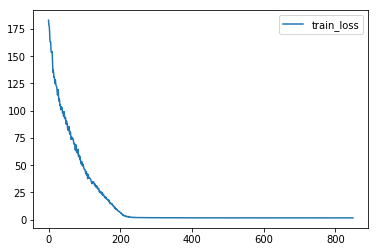

In [21]:
def plot_loss(train,name1="train_loss"):
    plt.plot(train, label=name1)
    plt.legend()

plot_loss(loss_values)